In [1]:
import numpy as np
from matplotlib import pyplot as plt

from skimage.transform import rescale, resize, radon, iradon
from scipy.stats import mode

from utils2 import *
import h5py

/home/everett/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Load Data.

Center finder works on 2D sinograms so select a sinogram along the y axis and load the data as (x, theta)

In [2]:
#h_sino = h5py.File('./sinograms/tomo_00001/tomo_00001.h5', 'r')
data = np.load('./sinograms/tomo_00064_to_00067/tomo_00066.npy')
#h_sino = h5py.File('./phantoms/phantom_00002/phantom_00002.h5','r')
#data, theta = tomobank_phantom_sino('./phantoms/phantom_00008/phantom_00008.h5')
print(data.shape)
#print(np.max(theta))

(350, 10, 450)


# Center finding on data and data with simulated.

Contrast ratio of input data:            0.2311438162813765
Contrast ratio of low exposure data:     1.6263032587282567e-19 

Contrast ratio of input row sum:         3.243867278740139e-13
Contrast ratio of low exposure row sum:  9.706862050262718e-18


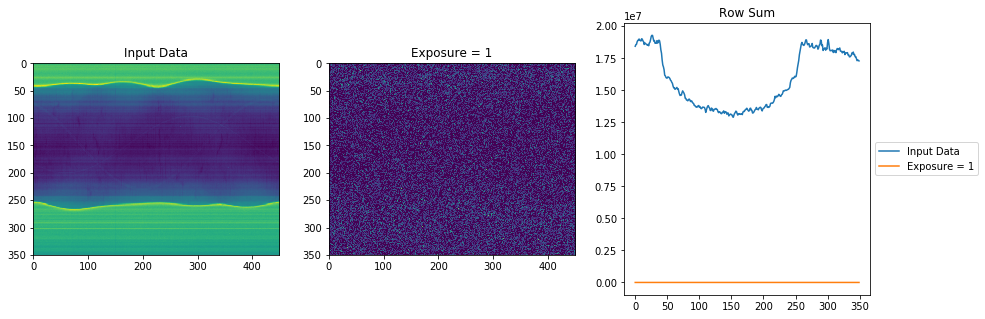

In [3]:
## Define exposure and bit_depth for simulated data (enter None for real data)
exposure = 1
bit_depth = None

## Choose to sum along Y axis or to select a slice 
sinogram = data[:,0,:] #select a slice
image_center = sinogram.shape[0]/2

## Add noise
sinogram_noise, sinogram_noise_snr = add_noise2(sinogram, exposure, bit_depth = bit_depth)

## Sum along theta
rowsum = np.sum(sinogram, axis=1)
rowsum_n = np.sum(sinogram_noise, axis=1)

## Print contrast ratio of arrays
## Contrast ratio is defined as the ratio of the max difference pixel values to
## the difference between minimum and maximum allowed values for the arrays dtype

print('Contrast ratio of input data:           ',  contrast_ratio(sinogram))
print('Contrast ratio of low exposure data:    ', contrast_ratio(sinogram_noise), '\n')
print('Contrast ratio of input row sum:        ',  contrast_ratio(rowsum))
print('Contrast ratio of low exposure row sum: ', contrast_ratio(rowsum_n))

## Plot ##
imimplot(sinogram, sinogram_noise, (rowsum, rowsum_n),
         ('Input Data', 'Exposure = ' + str(exposure)), title = 'Row Sum')

# Select window size, shifting range. Find center

0.0
1.1823431123048067e-11
-5.960464477539063e-08
-1.3642420526593924e-11
1.1920928955078125e-07
9.094947017729282e-13
5.066394805908203e-07
1.8189894035458565e-11
-2.086162567138672e-07
-1.6370904631912708e-11
1.7881393432617188e-07
-9.094947017729282e-13
1.7881393432617188e-07
9.094947017729282e-13
3.2782554626464844e-07
1.8189894035458565e-12
2.384185791015625e-07
-8.185452315956354e-12
1.1920928955078125e-07
5.9117155615240335e-12
7.450580596923828e-07
0.0
-5.066394805908203e-07
-5.4569682106375694e-12
4.470348358154297e-07
-1.3642420526593924e-12
-3.2782554626464844e-07
4.547473508864641e-12
-1.7881393432617188e-07
4.547473508864641e-12
-4.470348358154297e-07
-5.002220859751105e-12
-6.258487701416016e-07
4.092726157978177e-12
-5.960464477539063e-08
-7.275957614183426e-12
-4.172325134277344e-07
-1.5006662579253316e-11
-2.8312206268310547e-07
1.5916157281026244e-11
-5.960464477539063e-08
-1.2732925824820995e-11
-1.7881393432617188e-07
9.094947017729282e-13
-5.066394805908203e-07
-2.

2.980232238769531e-07
2.4959444999694824e-07
5.587935447692871e-09
1.564621925354004e-07
-2.0489096641540527e-08
2.551823854446411e-07
-7.301568984985352e-07
1.955777406692505e-07
2.2631138563156128e-07
-1.51805579662323e-07
-2.2631138563156128e-07
-4.284083843231201e-08
-6.51925802230835e-08
1.564621925354004e-07
-5.19677996635437e-07
9.313225746154785e-09
-7.450580596923828e-08
-7.82310962677002e-08
-1.341104507446289e-07
-4.842877388000488e-08
1.6763806343078613e-07
-2.123415470123291e-07
-1.043081283569336e-07
-8.195638656616211e-08
-3.129243850708008e-07
5.066394805908203e-07
-4.470348358154297e-07
-2.682209014892578e-07
7.227063179016113e-07
-5.438923835754395e-07
-4.544854164123535e-07
1.564621925354004e-07
3.2782554626464844e-07
5.960464477539062e-07
-1.4156103134155273e-07
2.8312206268310547e-07
-1.9371509552001953e-07
8.940696716308594e-08
-2.9802322387695312e-08
5.960464477539063e-08
-1.043081283569336e-07
-2.9802322387695312e-08
-1.4901161193847656e-08
-8.940696716308594e-0

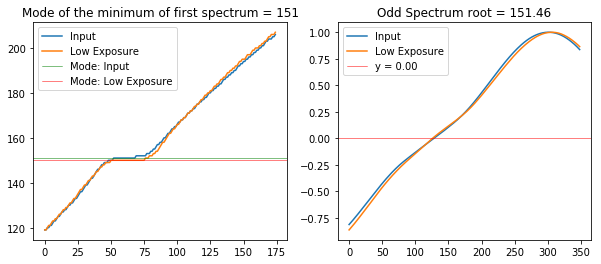

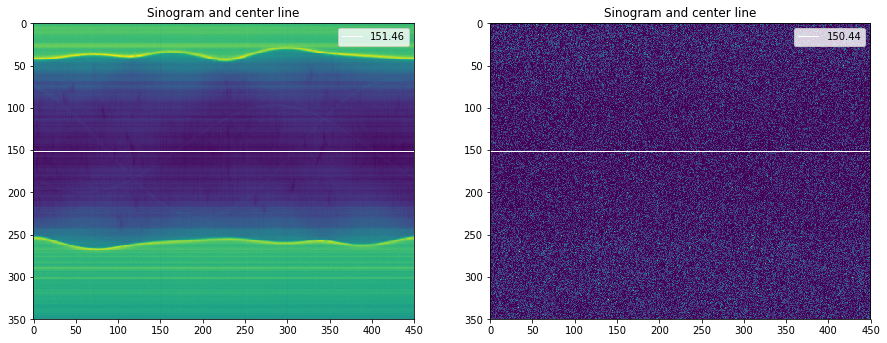

In [4]:
## Define scan area and range
window = sinogram_noise.shape[0]//2
shifting_range = sinogram_noise.shape[0]-window

## Collect the 1st FFT bin
bins = []
bins_n = []
for i in range(shifting_range):
    bins.append(window_bins(sinogram, window, i, fbins = [1])[0])
    bins_n.append(window_bins(sinogram_noise, window, i, fbins = [1])[0])

## Fit curve to find zero crossing and thus center.
root, spline = spline_root(np.imag(bins), window)
root_n, spline_n = spline_root(np.imag(bins_n), window)

## Find mode of the minimum of the real component of first spectrum
fsm = first_spectrum_min(sinogram, window)
fsm_n = first_spectrum_min(sinogram_noise, window)
fsm_mode = mode(fsm)[0][0]
fsm_n_mode = mode(fsm_n)[0][0]

## Plot results
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(fsm, label = 'Input')
plt.plot(fsm_n, label = 'Low Exposure')
plt.axhline(fsm_mode, color='g', linewidth = .5, label = 'Mode: Input')
plt.axhline(fsm_n_mode, color='r', linewidth = .5, label = 'Mode: Low Exposure')
plt.title('Mode of the minimum of first spectrum = ' + str(fsm_mode))
plt.legend()
plt.subplot(122)
plt.plot(np.arange(len(np.imag(bins)))*2,np.imag(bins)/np.max(np.imag(bins)), label = 'Input')
plt.plot(np.arange(len(np.imag(bins_n)))*2,np.imag(bins_n)/np.max(np.imag(bins_n)), label = 'Low Exposure')
plt.title('Odd Spectrum root = ' + str(root[0])[0:6])
plt.axhline(0, color = 'r', linewidth = .5, label = 'y = 0.00')
plt.legend()
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(sinogram)
plt.title('Sinogram and center line')
plt.axhline(root, color='w', linewidth = 1, label = str(root[0])[0:6])
plt.legend()
plt.subplot(122)
plt.imshow(sinogram_noise)
plt.title('Sinogram and center line')
plt.axhline(root, color='w', linewidth = 1, label = str(root_n[0])[0:6])
plt.legend()
plt.show()



# Plot the rowsum, fft[1] spectrum, and its even and odd components.

## This was for playing around with different spectra

In [5]:
#plots = list(np.arange(10)+np.floor(root-5)-window//2)
#DC_all, SYM_all = shift(sinogram_noise, window, plot=plots)